In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy import stats
from cooltools.lib import numutils

from helper import read_multi_model_number_data

### Reading the data

In [4]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_number"
df = read_multi_model_number_data(data_dir, keys_to_ignore = ["disruption_SCD", "insertion_SCD"])

### Correlations between backgrounds

In [5]:
for model_index in range(2):
    for background_index_0 in range(3):
        for background_index_1 in range(3):
            if background_index_0 > background_index_1:
                print("Model", model_index)
                print("\t - Correlation between backgrounds: ", background_index_0, background_index_1)
                perm_corr = round(stats.pearsonr(df[f"SCD_m0_bg{background_index_0}"], df[f"SCD_m0_bg{background_index_1}"]).statistic, 4)
                print("\t", perm_corr)

Model 0
	 - Correlation between backgrounds:  1 0
	 0.998
Model 0
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 0
	 - Correlation between backgrounds:  2 1
	 0.9928
Model 1
	 - Correlation between backgrounds:  1 0
	 0.998
Model 1
	 - Correlation between backgrounds:  2 0
	 0.9946
Model 1
	 - Correlation between backgrounds:  2 1
	 0.9928


### Splitting data into 5 percentile groups wrt insertion score

In [6]:
def get_num_sites(row):
    return len(row["orientation"])

df["number"] = df.apply(get_num_sites, axis=1)

df_sorted = df.sort_values(by='insertion_SCD').reset_index(drop=True)
df_sorted.loc[:249, 'insSCD_group'] = 'Group_0'
total_rows = len(df_sorted) - 250
rows_per_group = total_rows // 4
for i, group in enumerate(['Group_1', 'Group_2', 'Group_3', 'Group_4'], start=1):
    start_idx = 250 + (i - 1) * rows_per_group
    end_idx = start_idx + rows_per_group
    df_sorted.loc[start_idx:end_idx, 'insSCD_group'] = group
df_sorted.loc[250 + 3 * rows_per_group:, 'insSCD_group'] = 'Group_4'

number_df = df_sorted.groupby(["insSCD_group", "number"]).agg({"SCD": "mean"}).reset_index()

color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

max_num_sites = 40

### Plot with sites splitted into 5 groups by percentiles

Text(0, 0.5, 'Insertion Score')

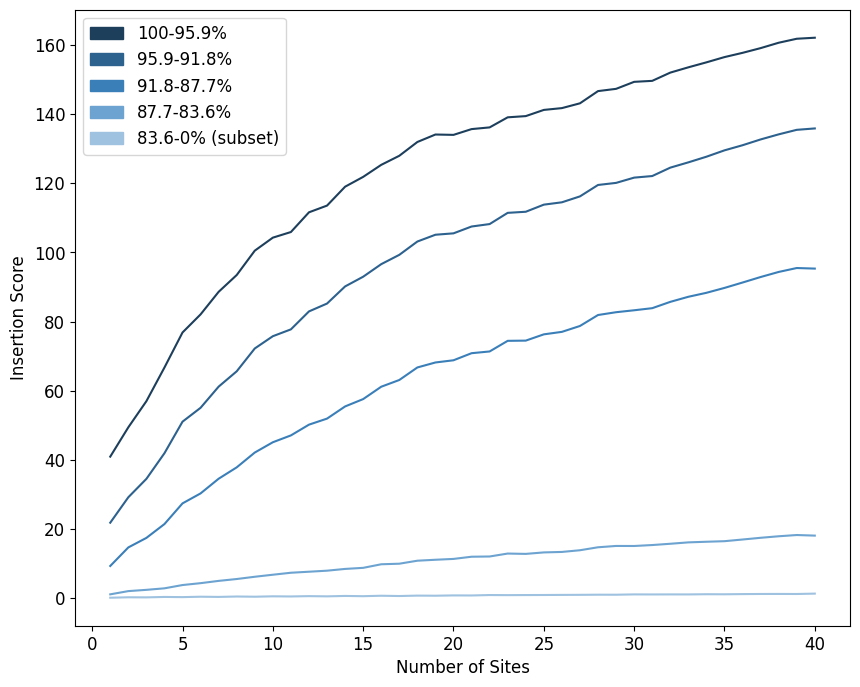

In [10]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, number_df[(number_df["insSCD_group"] == group)]["SCD"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="83.6-0% (subset)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

### As above, with smoothed lines

In [8]:
bin_size = 11

Text(0, 0.5, 'Insertion Score')

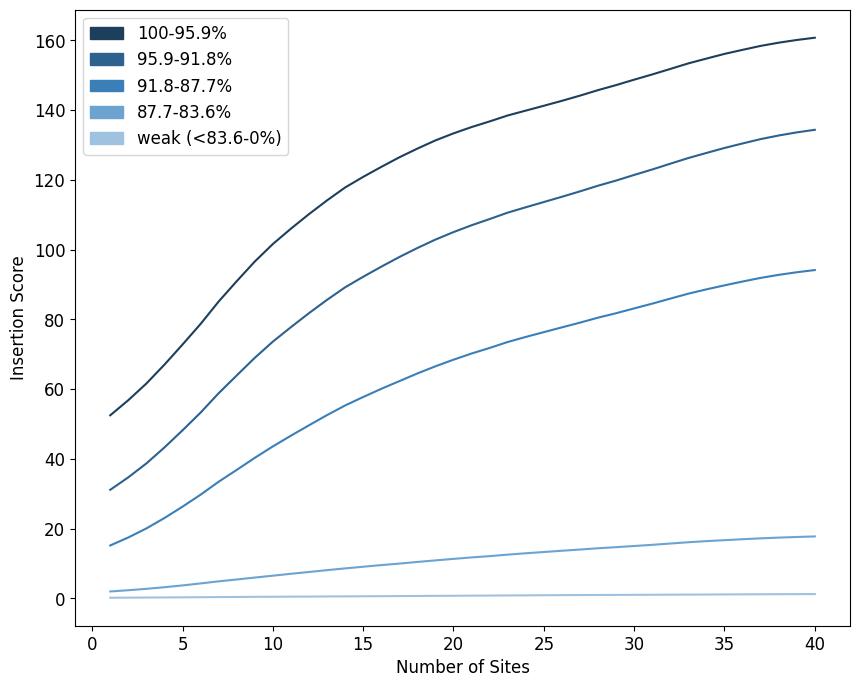

In [16]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6-0%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

### Plot with smoothed lines and 25-75 percentile bands

In [12]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [13]:
insSCDpercentiles_df = df_sorted.groupby(["insSCD_group", "number"])["SCD"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'Insertion Score')

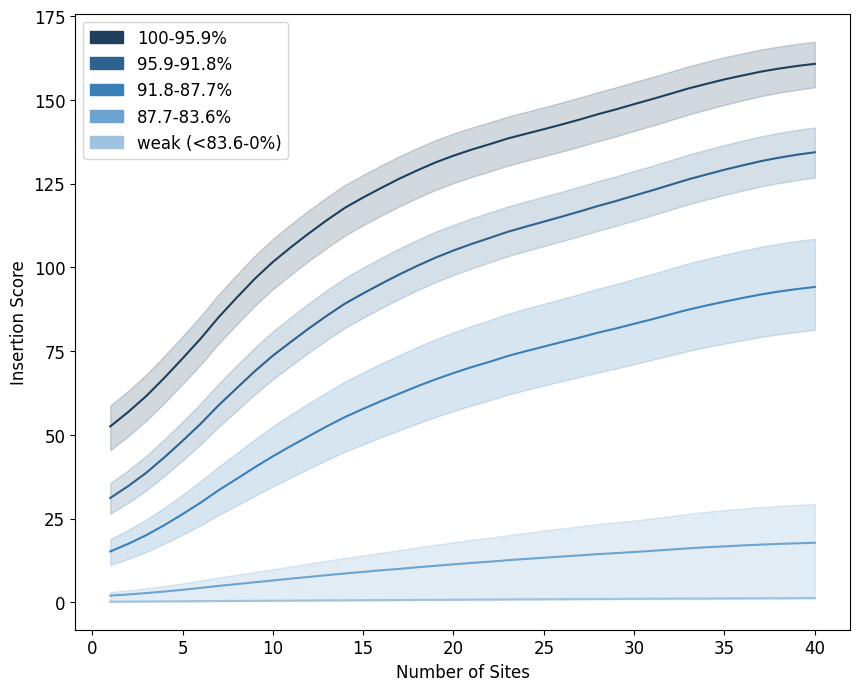

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    # if group != "Group_1":
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6-0%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

### Plotting up to 10 sites (fitting within 1 bin)

Text(0, 0.5, 'Insertion Score')

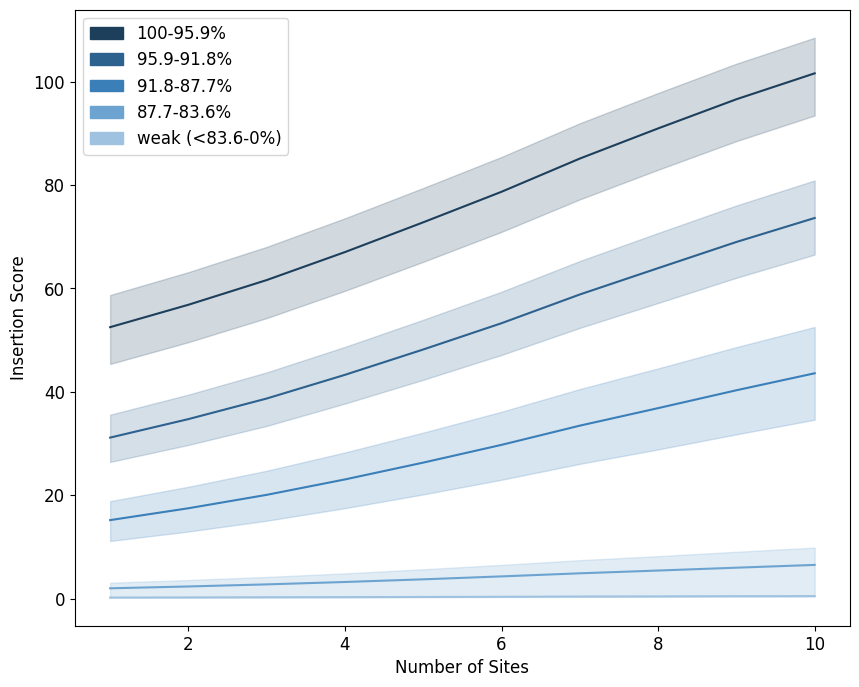

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1, 10+1)]

for group in number_df.insSCD_group.unique():
    # if group != "Group_1":
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size)[:10],
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)[:10]
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)[:10]

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6-0%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

### Plotting 10 random sites from high, medium, low insertion_SCD group

In [19]:
num_sites = 10
ten_high = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_sorted[df_sorted["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

Text(0, 0.5, 'Insertion SCD')

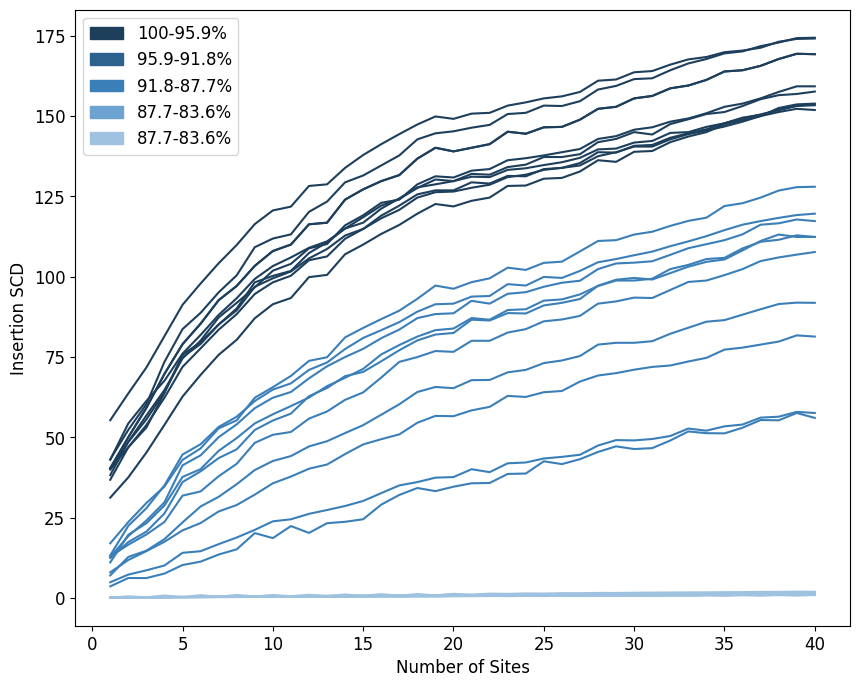

In [20]:
plt.figure(figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="87.7-83.6%")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion SCD")

### Plot with smoothed trends of 5 groups overlayed with 10 lines randomly chosen from the highest class

Text(0, 0.5, 'Insertion Score')

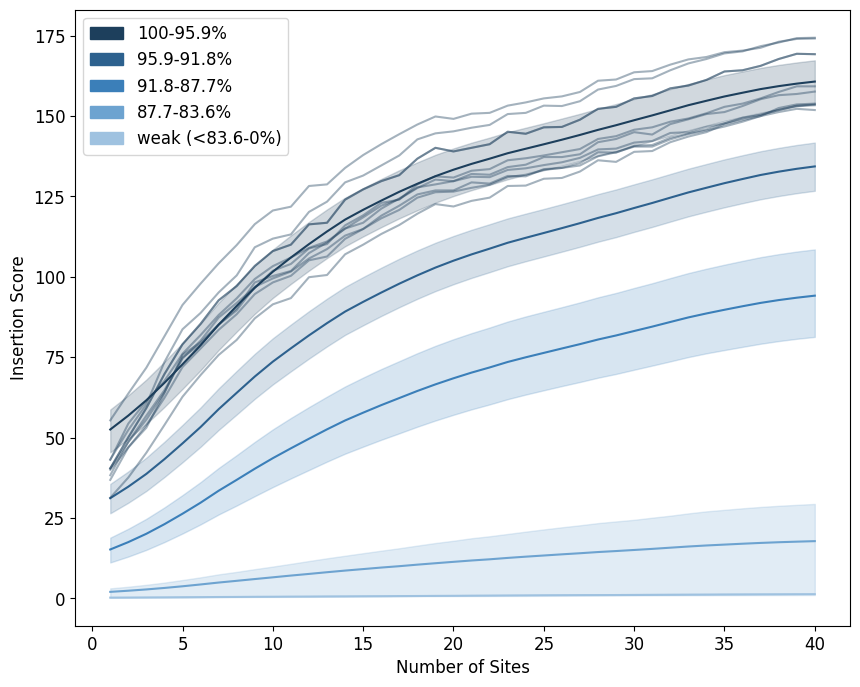

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,max_num_sites+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6-0%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

# plt.savefig("./plots/insertion_score_vs_sites_number.pdf", format="pdf", bbox_inches="tight")

### As above, for up to 10 sites

Text(0, 0.5, 'Insertion Score')

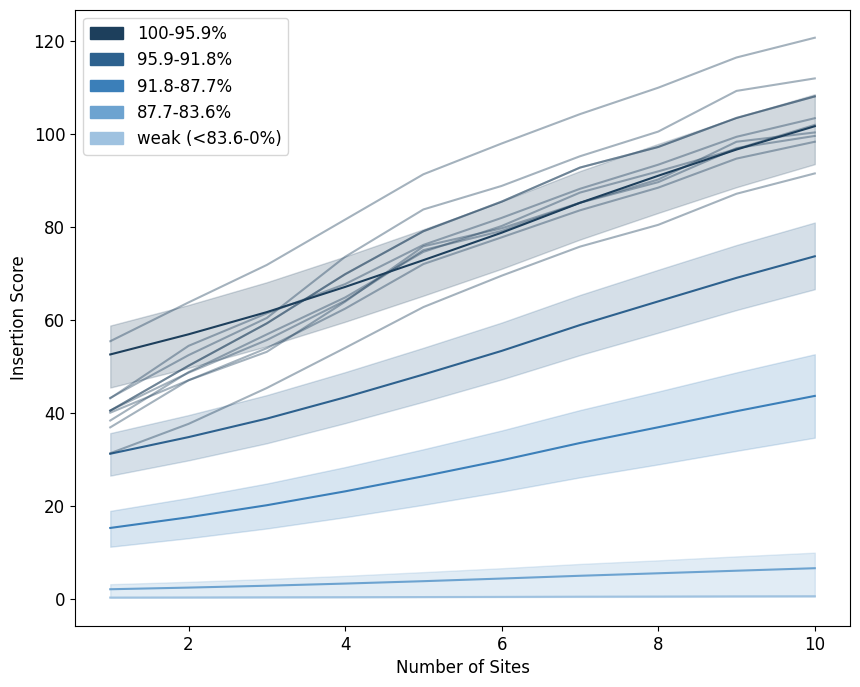

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
x = [x for x in range(1,10+1)]

for group in number_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(number_df[(number_df["insSCD_group"] == group)]["SCD"], bin_size)[:10],
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)[:10]
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)[:10]

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_sorted[(df_sorted["start"] == start_pos)].sort_values(by="number")["SCD"][:10], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="100-95.9%")
gr3_patch = mpatches.Patch(color="#2d618e", label="95.9-91.8%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="91.8-87.7%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="87.7-83.6%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6-0%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Number of Sites")
plt.ylabel("Insertion Score")

# plt.savefig("./plots/insertion_score_vs_sites_number_up10.pdf", format="pdf", bbox_inches="tight")